# Data compression using autoencoders

## Part 1 : data compressing using an autoencoder
### Necessary imports

In [1]:
from keras.layers import Input, Dense
from keras.models import Model
import matplotlib.pyplot as plt
import numpy as np

Using TensorFlow backend.


### Preparation of the dataset

In [2]:
from keras.datasets import mnist #collection of handwritten caracter images

#We normalize all values between 0 and 1 and we will flatten the 28x28 images into vectors of size 784
(x_train, _), (x_test, _) = mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

print(x_train.shape, x_test.shape)

(60000, 784) (10000, 784)


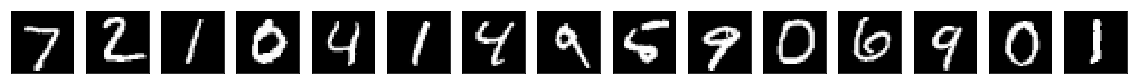

In [3]:
# Original data display
plt.figure(figsize=(20, 4))
n = 15 #number of elements to display

for i in range(n):
    ax = plt.subplot(1, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

### Preparation of the model

In [4]:
# Full Auto Encoder model: map an input to its reconstruction
encoding_dim = 28 # size of the encoded representations
input_unit_size = encoding_dim*encoding_dim #number of input nodes
n_hidden = 144 #number of nodes in the hidden layer

input_img = Input(shape=(input_unit_size,)) #input placeholder
encoded = Dense(n_hidden, activation='relu')(input_img)
decoded = Dense(input_unit_size, activation='sigmoid')(encoded)

autoencoder = Model(input_img, decoded) #same number of neurons in input and output

#Compilation of the model
autoencoder.compile(loss='binary_crossentropy', optimizer='adadelta')

### Training of the model

In [5]:
autoencoder.fit(x_train, x_train, epochs=30, batch_size=256)

Epoch 1/30
60000/60000 [==============================] - 6s 97us/step - loss: 0.3339
Epoch 2/30
60000/60000 [==============================] - 5s 87us/step - loss: 0.2464: 0s - loss: 0
Epoch 3/30
60000/60000 [==============================] - 6s 96us/step - loss: 0.2176
Epoch 4/30
60000/60000 [==============================] - 7s 121us/step - loss: 0.1978
Epoch 5/30
60000/60000 [==============================] - 6s 104us/step - loss: 0.1844
Epoch 6/30
60000/60000 [==============================] - 7s 111us/step - loss: 0.1744 0s - loss: - ETA: 0s - loss: 0.17
Epoch 7/30
60000/60000 [==============================] - 5s 88us/step - loss: 0.1663
Epoch 8/30
60000/60000 [==============================] - 5s 88us/step - loss: 0.1593
Epoch 9/30
60000/60000 [==============================] - 6s 97us/step - loss: 0.1533
Epoch 10/30
60000/60000 [==============================] - 6s 104us/step - loss: 0.1479
Epoch 11/30
60000/60000 [==============================] - 6s 93us/step - loss: 0.1431


In [6]:
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 144)               113040    
_________________________________________________________________
dense_2 (Dense)              (None, 784)               113680    
Total params: 226,720
Trainable params: 226,720
Non-trainable params: 0
_________________________________________________________________


### We will also create separate encoding and decoding functions which can be used to extract latent features


In [7]:
#Separate encoder model
encoder = Model(input_img, encoded)

#Separate decoder model
encoded_input = Input(shape=(n_hidden,))
# last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]
# decoder
decoder = Model(encoded_input, decoder_layer(encoded_input))

### Predictions

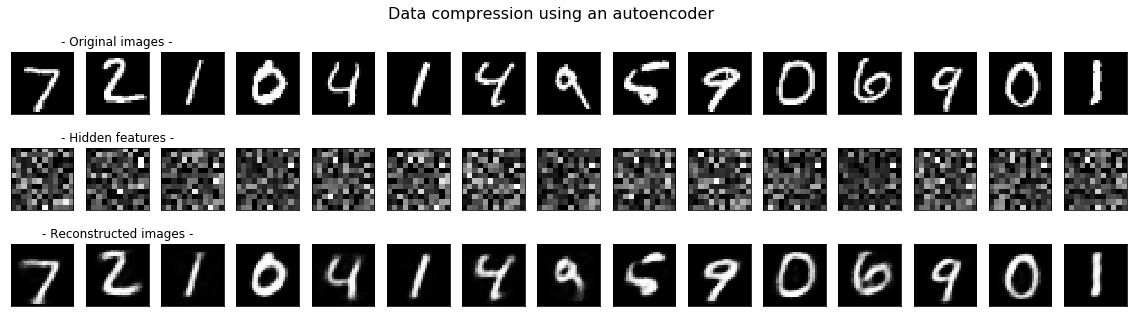

In [8]:
# encode and decode some images from test set
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)

fig = plt.figure(figsize=(20, 5))

def results_display(step, i, n, img_table):
    subplot_index = 0 if step == 1 else (n if step == 2 else 2*n)
    img_size = 28 if step != 2 else 12
    msg = "- Original images -" if step == 1 else ("- Hidden features -" if step == 2 else "- Reconstructed images -")
    
    ax = plt.subplot(3, n, i + 1 + subplot_index)
    plt.imshow(img_table[i].reshape(img_size, img_size))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    if i == 1:
        ax.set_title(msg)
    return ax


n = 15 # number of elements to display
for i in range(n):
    # display original
    ax = results_display(1, i, n, x_test)
    
    # display hidden features
    ax1 = results_display(2, i, n, encoded_imgs)
        
    # display reconstruction
    ax2 = results_display(3, i, n, decoded_imgs)
    
fig.suptitle("Data compression using an autoencoder", fontsize=16)
plt.show()


## Part 2 : what about the noise reduction?
### We add random noises to the MINST image data and use them as input for training

In [9]:
def add_noise(x, noise_factor=0.3):
    x = x + np.random.randn(*x.shape) * noise_factor
    x = x.clip(0., 1.)
    return x
    
x_train_noisy = add_noise(x_train)
x_test_noisy  = add_noise(x_test)

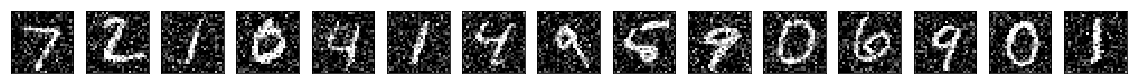

In [10]:
# Noisy data display
plt.figure(figsize=(20, 4))
n = 15 #number of elements to display

for i in range(n):
    ax = plt.subplot(1, n, i + 1)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

### We train a new autoencoder with the noisy data as input and the original data as expected output

In [11]:
# Full denoising auto encoder model: map an input to its reconstruction
encoding_dim = 28 # size of the encoded representations
input_unit_size = encoding_dim*encoding_dim #number of input nodes
n_hidden = 144 #number of nodes in the hidden layer

input_img = Input(shape=(input_unit_size,)) #input placeholder
encoded = Dense(n_hidden, activation='relu')(input_img)
decoded = Dense(input_unit_size, activation='sigmoid')(encoded)

denoising_autoencoder = Model(input_img, decoded)

#Compilation of the model
denoising_autoencoder.compile(loss='binary_crossentropy', optimizer='adadelta')

### During the training, the autoencoder learns to extract important features from input images and ignores the image noises because the labels have no noise

In [12]:
denoising_autoencoder.fit(x_train_noisy, x_train, epochs=50, batch_size=256)

Epoch 1/50
60000/60000 [==============================] - 5s 83us/step - loss: 0.3179
Epoch 2/50
60000/60000 [==============================] - 5s 75us/step - loss: 0.2544
Epoch 3/50
60000/60000 [==============================] - 4s 72us/step - loss: 0.2318
Epoch 4/50
60000/60000 [==============================] - 5s 75us/step - loss: 0.2113
Epoch 5/50
60000/60000 [==============================] - 4s 74us/step - loss: 0.1962
Epoch 6/50
60000/60000 [==============================] - 5s 85us/step - loss: 0.1850
Epoch 7/50
60000/60000 [==============================] - 5s 81us/step - loss: 0.1761
Epoch 8/50
60000/60000 [==============================] - 4s 71us/step - loss: 0.1687
Epoch 9/50
60000/60000 [==============================] - 4s 74us/step - loss: 0.1623
Epoch 10/50
60000/60000 [==============================] - 4s 71us/step - loss: 0.1568
Epoch 11/50
60000/60000 [==============================] - 4s 70us/step - loss: 0.1519
Epoch 12/50
60000/60000 [===========================

### We will also create separate encoding and decoding functions which can be used to extract latent features


In [13]:
#Separate encoder model
denoising_encoder = Model(input_img, encoded)

#Separate decoder model
encoded_input = Input(shape=(n_hidden,))
# last layer of the autoencoder model
decoder_layer = denoising_autoencoder.layers[-1]
# decoder
denoising_decoder = Model(encoded_input, decoder_layer(encoded_input))

### Let’s pass the noisy test images to the denoising autoencoder to see the restored images

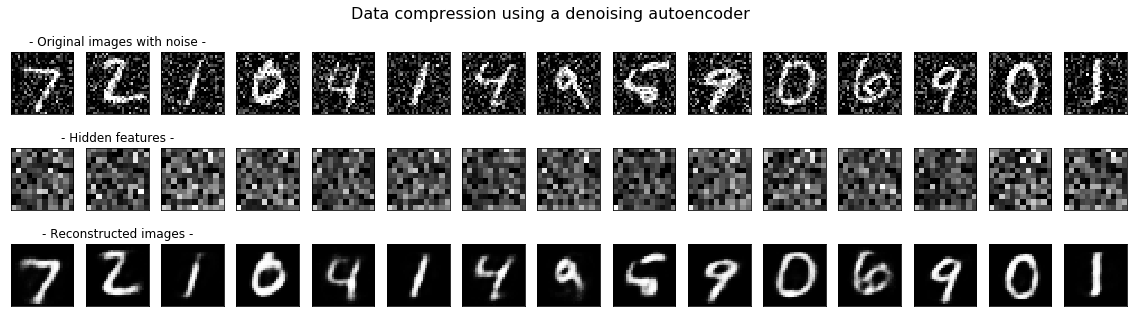

In [15]:
encoded_noisy_imgs = denoising_encoder.predict(x_test_noisy)
decoded_noisy_imgs = denoising_decoder.predict(encoded_noisy_imgs)

fig = plt.figure(figsize=(20, 5))

def results_display(step, i, n, img_table):
    subplot_index = 0 if step == 1 else (n if step == 2 else 2*n)
    img_size = 28 if step != 2 else 12
    msg = "- Original images with noise -" if step == 1 else ("- Hidden features -" if step == 2 else "- Reconstructed images -")
    
    ax = plt.subplot(3, n, i + 1 + subplot_index)
    plt.imshow(img_table[i].reshape(img_size, img_size))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    if i == 1:
        ax.set_title(msg)
    return ax


n = 15 # number of elements to display
for i in range(n):
    # display original
    ax = results_display(1, i, n, x_test_noisy)
    
    # display hidden features
    ax1 = results_display(2, i, n, encoded_noisy_imgs)
        
    # display reconstruction
    ax2 = results_display(3, i, n, decoded_noisy_imgs)
    
fig.suptitle("Data compression using a denoising autoencoder", fontsize=16)
plt.show()